<a href="https://colab.research.google.com/github/ketoin23/Sarcasm-Detection-in-Headlines/blob/main/Glove_Sarcasm_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
! pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00


<div style="border-radius:7px;
            border : black solid;
            background-color: #006400;
            font-size:160%;
            text-align: left">
    
<h1 style='; border:0; border-radius: 10px; text-shadow: 1px 1px black; font-weight: bold; color:#F6F6E8'><center> SARCASTIC HEADLINES CLASSIFICATION 🎭</center></h1>

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#808000 ;font-family:arial;color:#FFFFFF;font-size:150%;text-align:center;border-radius:55px 1px;">Import necessary libraries...</p>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn import ensemble
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from termcolor import colored
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from tqdm import tqdm
import re

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.preprocessing.text import Tokenizer

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

print(colored("\nLIBRARIES WERE SUCCESFULLY IMPORTED...", "green"))


LIBRARIES WERE SUCCESFULLY IMPORTED...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#808000 ;font-family:arial;color:#FFFFFF;font-size:150%;text-align:center;border-radius:55px 1px;"> Load the dataset...</p>

In [ ]:
file = open("/content/drive/MyDrive/GloveEmbeddings/Sarcasm_Headlines_Dataset_v2.json")
json_data = [json.loads(line) for line in file]
json_data[0:5]

[{'is_sarcastic': 1,
  'headline': 'thirtysomething scientists unveil doomsday clock of hair loss',
  'article_link': 'https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205'},
 {'is_sarcastic': 0,
  'headline': 'dem rep. totally nails why congress is falling short on gender, racial equality',
  'article_link': 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207'},
 {'is_sarcastic': 0,
  'headline': 'eat your veggies: 9 deliciously different recipes',
  'article_link': 'https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html'},
 {'is_sarcastic': 1,
  'headline': 'inclement weather prevents liar from getting to work',
  'article_link': 'https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031'},
 {'is_sarcastic': 1,
  'headline': "mother comes pretty close to using word 'streaming' correctly",
  'article_link': 'https://www.theonion.com/mother-comes-pretty-

In [ ]:
texts = []
labels = []
urls = []

for item in json_data:
    texts.append(item["headline"])
    labels.append(item["is_sarcastic"])
    urls.append(item["article_link"])

In [ ]:
texts[0:10]

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep. totally nails why congress is falling short on gender, racial equality',
 'eat your veggies: 9 deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 "mother comes pretty close to using word 'streaming' correctly",
 'my white inheritance',
 '5 ways to file your taxes with less stress',
 "richard branson's global-warming donation nearly as much as cost of failed balloon trips",
 'shadow government getting too large to meet in marriott conference room b',
 'lots of parents know this scenario']

In [ ]:
labels[0:10]

[1, 0, 0, 1, 1, 0, 0, 1, 1, 0]

In [ ]:
urls[0:5] #we do not need the urls and will not use them

['https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205',
 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207',
 'https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html',
 'https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031',
 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546']

In [ ]:
len(texts), len(labels), len(urls)

(28619, 28619, 28619)

In [ ]:
df = pd.DataFrame()
df["text"] = texts
df["label"] = labels
df.head(n = 10).style.background_gradient(cmap = "autumn")

,text,label
0,thirtysomething scientists unveil doomsday clock of hair loss,1
1,"dem rep. totally nails why congress is falling short on gender, racial equality",0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting to work,1
4,mother comes pretty close to using word 'streaming' correctly,1
5,my white inheritance,0
6,5 ways to file your taxes with less stress,0
7,richard branson's global-warming donation nearly as much as cost of failed balloon trips,1
8,shadow government getting too large to meet in marriott conference room b,1
9,lots of parents know this scenario,0


In [ ]:
#get basic information about dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    28619 non-null  object
 1   label   28619 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


In [ ]:
#check whether there are duplicated values

df.duplicated().sum()

116

In [ ]:
# drop duplicated values from the dataset

df.drop_duplicates(inplace = True)

In [ ]:
#get the number of classes of the "label" variable of dataset

df.groupby("label").count().style.background_gradient(cmap = "autumn")

,text
label,
0,14951
1,13552


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#808000 ;font-family:arial;color:#FFFFFF;font-size:150%;text-align:center;border-radius:55px 1px;">Visualization with Word Cloud</p>

<function matplotlib.pyplot.show(close=None, block=None)>

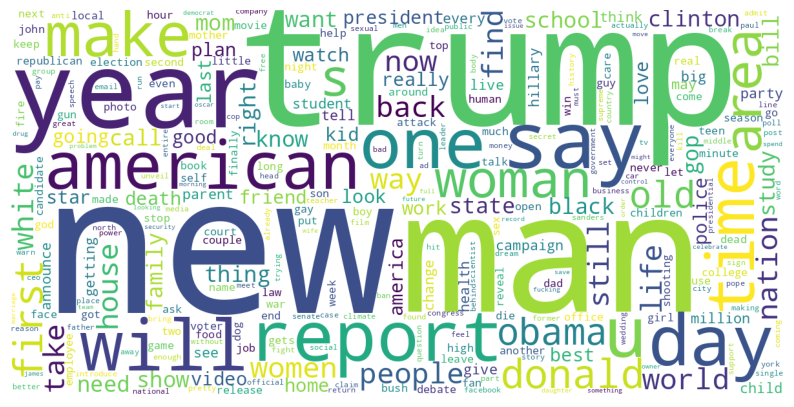

In [ ]:
text = " ".join(i for i in df.text)

wc = WordCloud(background_color = "white",
               width = 1200,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 300,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [10, 10])
plt.imshow(wc)
plt.axis("off")
plt.show

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#808000 ;font-family:arial;color:#FFFFFF;font-size:150%;text-align:center;border-radius:55px 1px;">Preprocess the dataset</p>

In [ ]:
#convert uppercase letters to lowercase letters

df["text"] = df["text"].apply(lambda x: " ".join(x.lower() for x in x.split()))

print(colored("\nCONVERTED SUCCESFULLY...", "green"))


CONVERTED SUCCESFULLY...


In [ ]:
#delete punctuation marks

df["text"] = df["text"].str.replace('[^\w\s]','')

print(colored("\nDELETED PUNCTUATION MARKS SUCCESFULLY...", "green"))


DELETED PUNCTUATION MARKS SUCCESFULLY...


In [ ]:
#delete numbers

df["text"] = df["text"].str.replace('\d','')

print(colored("\n NUMBERS DELETED SUCCESFULLY...", "green"))


 NUMBERS DELETED SUCCESFULLY...


In [ ]:
#delete stopwords

sw = stopwords.words("english")
df["text"] = df["text"].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

print(colored("\nSTOPWORDS DELETED SUCCESFULLY...", "green"))


STOPWORDS DELETED SUCCESFULLY...


In [ ]:
#lemmatization. That is, we get the roots of the words

df["text"] = df["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print(colored("\nDONE SUCCESFULLY...", "green"))


DONE SUCCESFULLY...


In [ ]:
#look at the latest condition of the dataset

df.head(n = 10).style.background_gradient(cmap = "summer")

,text,label
0,thirtysomething scientist unveil doomsday clock hair loss,1
1,dem rep totally nail congress falling short gender racial equality,0
2,eat veggie deliciously different recipe,0
3,inclement weather prevents liar getting work,1
4,mother come pretty close using word streaming correctly,1
5,white inheritance,0
6,way file tax le stress,0
7,richard bransons globalwarming donation nearly much cost failed balloon trip,1
8,shadow government getting large meet marriott conference room b,1
9,lot parent know scenario,0


In [ ]:
df.text[0]

'thirtysomething scientist unveil doomsday clock hair loss'

In [ ]:
!unzip '/content/drive/MyDrive/GloveEmbeddings/glove.6B.zip'

Archive:  /content/drive/MyDrive/GloveEmbeddings/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#808000 ;font-family:arial;color:#FFFFFF;font-size:150%;text-align:center;border-radius:55px 1px;">Vectorize dataset with Glove method...</p>

In [ ]:
embedding_file = '/content/glove.6B.300d.txt'
embeddings_dict = {}
with open(embedding_file, 'r', encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs

texts = df['text'].values
labels = df['label'].values

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

In [ ]:
from keras_preprocessing.sequence import pad_sequences
max_length = 300
data = pad_sequences(sequences, maxlen=max_length)

# Create the embedding matrix
embedding_dim = 300
num_words = min(len(word_index) + 1, 5000)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= 5000:
        continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding

model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))

In [ ]:
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          1500000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,719,777
Trainable params: 219,777
Non-trainable params: 1,500,000
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
713/713 [==============================] - 24s 19ms/step - loss: 0.5573 - accuracy: 0.7148 - val_loss: 0.4963 - val_accuracy: 0.7521
Epoch 2/10
713/713 [==============================] - 14s 20ms/step - loss: 0.4481 - accuracy: 0.7844 - val_loss: 0.4473 - val_accuracy: 0.7818
Epoch 3/10
713/713 [==============================] - 10s 14ms/step - loss: 0.3840 - accuracy: 0.8240 - val_loss: 0.4465 - val_accuracy: 0.7874
Epoch 4/10
713/713 [==============================] - 11s 15ms/step - loss: 0.3211 - accuracy: 0.8597 - val_loss: 0.4504 - val_accuracy: 0.7934
Epoch 5/10
713/713 [==============================] - 11s 16ms/step - loss: 0.2581 - accuracy: 0.8902 - val_loss: 0.4766 - val_accuracy: 0.7872
Epoch 6/10
713/713 [==============================] - 11s 15ms/step - loss: 0.3354 - accuracy: 0.8516 - val_loss: 0.4778 - val_accuracy: 0.7886
Epoch 7/10
713/713 [==============================] - 13s 19ms/step - loss: 0.1981 - accuracy: 0.9183 - val_loss: 0.5240 - val_accuracy:

In [ ]:
# Save the model to a file
model.save('glove_lstm.h5')

#Demo

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
sentence = 'thirtysomething scientist unveil doomsday clock hair loss'
def pre(text):
    text = text.lower()
    words = nltk.word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    text = " ".join(words)

    return text

sentence = pre(sentence)

input_sequence = tokenizer.texts_to_sequences([sentence])
input_sequence = pad_sequences(input_sequence, maxlen=300)

pred = model.predict(input_sequence)
if pred >= 0.5:
  pred = 1
else:
  pred = 0

pred

1/1 [==============================] - 0s 50ms/step


1